In [24]:
import math
import pickle

import pandas as pd
import numpy as np
import os.path as op
# import pylab as pl

from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors

# Load data

In [61]:
embd_df = pd.read_pickle('embd_df.pkl')
morgan_df = pd.read_pickle('morgan_df.pkl')

In [42]:
names=["origin", "top_1", "top_2", "top_3", "top_4", "top_5", "top_6", "top_7", "top_8", "top_9", "top_10"]
embd_df = pd.read_csv('embd_neighbours/embd_neighbours_100K.csv',
                      header=None,
                      index_col=None,
                      delim_whitespace=True,
                      names=names)
morgan_df = pd.read_csv('embd_neighbours/morgan_fngp_neighbours_100K.csv',
                        header=None,
                        index_col=None,
                        delim_whitespace=True,
                        names=names)

In [43]:
embd_df = embd_df.drop(columns=names[4:])
morgan_df = morgan_df.drop(columns=names[4:])

# Sanitize

In [45]:
def sanitize(row):
    m = Chem.MolFromSmiles(row)
    if m:
        try:
            Chem.SanitizeMol(m)
            return m
        except Exception as e:
            print(e)
            return None

In [46]:
%%time

for c in tqdm(embd_df.columns):
    embd_df[c+'_mol'] = embd_df[c].apply(sanitize)

100%|██████████| 4/4 [03:18<00:00, 49.64s/it]

CPU times: user 2min 37s, sys: 16.6 s, total: 2min 53s
Wall time: 3min 18s


In [47]:
embd_df.to_pickle("embd_df.pkl")

In [48]:
%%time

for c in tqdm(morgan_df.columns):
    morgan_df[c+'_mol'] = morgan_df[c].apply(sanitize)

100%|██████████| 4/4 [02:27<00:00, 36.82s/it]

CPU times: user 2min 21s, sys: 3.28 s, total: 2min 24s
Wall time: 2min 27s


In [49]:
morgan_df.to_pickle("morgan_df.pkl")

# Molecular descriptors

# Synthetic accessibility score

In [18]:
_fscores = None


def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    # generate the full path filename:
#     if name == "fpscores":
#         name = op.join(op.dirname(__file__), name)
    _fscores = pickle.load(gzip.open('%s.pkl.gz' % name))
    outDict = {}
    for i in _fscores:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict

In [38]:
def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro


def calculateScore(m):
    if _fscores is None:
        readFragmentScores()
    
#     m = Chem.MolFromSmiles(smiles_string)
    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m, 2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf

    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1

    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    #  macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)

    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty

    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5

    sascore = score1 + score2 + score3

    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0

    return sascore

In [50]:
%%time

for c in tqdm(embd_df.columns):
    if '_mol' in c:
        embd_df[c+'_sascore'] = embd_df[c].apply(calculateScore)

100%|██████████| 8/8 [03:10<00:00, 23.77s/it]

CPU times: user 2min 33s, sys: 22.4 s, total: 2min 55s
Wall time: 3min 10s


In [51]:
%%time

for c in tqdm(morgan_df.columns):
    if '_mol' in c:
        morgan_df[c+'_sascore'] = morgan_df[c].apply(calculateScore)

100%|██████████| 8/8 [02:34<00:00, 19.29s/it]

CPU times: user 2min 18s, sys: 11.3 s, total: 2min 30s
Wall time: 2min 34s


In [54]:
embd_df.to_pickle("embd_df.pkl")
morgan_df.to_pickle("morgan_df.pkl")

# Molecular weight

In [64]:
from rdkit.Chem.Descriptors import ExactMolWt

def get_mol_weight_from_mol(m):
    return ExactMolWt(Chem.AddHs(m))

In [66]:
%%time

for c in tqdm(embd_df.columns):
    if c.endswith('_mol'):
        embd_df[c+'_mw'] = embd_df[c].apply(get_mol_weight_from_mol)
        
for c in tqdm(morgan_df.columns):
    if c.endswith('_mol'):
        morgan_df[c+'_mw'] = morgan_df[c].apply(get_mol_weight_from_mol)


100%|██████████| 12/12 [00:37<00:00,  3.13s/it][A

100%|██████████| 12/12 [00:35<00:00,  2.92s/it][A

CPU times: user 55.2 s, sys: 12.8 s, total: 1min 7s
Wall time: 1min 12s


In [69]:
embd_df.to_pickle("embd_df.pkl")
morgan_df.to_pickle("morgan_df.pkl")

# logP

In [70]:
from rdkit.Chem.Crippen import MolLogP

def get_logp_from_mol(m):
    return MolLogP(Chem.AddHs(m))

In [71]:
%%time

for c in tqdm(embd_df.columns):
    if c.endswith('_mol'):
        embd_df[c+'_logp'] = embd_df[c].apply(get_logp_from_mol)
        
for c in tqdm(morgan_df.columns):
    if c.endswith('_mol'):
        morgan_df[c+'_logp'] = morgan_df[c].apply(get_logp_from_mol)


100%|██████████| 16/16 [03:28<00:00, 13.01s/it][A

100%|██████████| 16/16 [03:21<00:00, 12.58s/it][A

CPU times: user 6min 35s, sys: 2.24 s, total: 6min 37s
Wall time: 6min 49s


In [75]:
embd_df.to_pickle("embd_df.pkl")
morgan_df.to_pickle("morgan_df.pkl")

# TPSA

In [76]:
from rdkit.Chem.rdMolDescriptors import CalcTPSA

def get_tpsa(m):
    return CalcTPSA(Chem.AddHs(m))

In [77]:
%%time

for c in tqdm(embd_df.columns):
    if c.endswith('_mol'):
        embd_df[c+'_tpsa'] = embd_df[c].apply(get_tpsa)
        
for c in tqdm(morgan_df.columns):
    if c.endswith('_mol'):
        morgan_df[c+'_tpsa'] = morgan_df[c].apply(get_tpsa)


100%|██████████| 20/20 [00:29<00:00,  1.46s/it][A

100%|██████████| 20/20 [00:24<00:00,  1.21s/it][A

CPU times: user 50.1 s, sys: 302 ms, total: 50.5 s
Wall time: 53.4 s


# Plot results

In [240]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
flat = ["red", "blue", "green", "orange"]
sns.set_palette(flat)

def plot_df(df, name):
    fig, ax = pyplot.subplots(nrows=2, ncols=2, figsize=(16,12))

    sns.distplot(df.origin_mol_mw, hist = False, kde = True, kde_kws = {'linewidth': 2}, label="origin", ax=ax[0,0])
    sns.distplot(df.top_1_mol_mw, hist = False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 2}, label="top_1", ax=ax[0,0])
    sns.distplot(df.top_2_mol_mw, hist = False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 2}, label="top_2", ax=ax[0,0])
    sns.distplot(df.top_3_mol_mw, hist = False, kde = True, kde_kws = {'linestyle':'dashdot', 'linewidth': 2}, label="top_3", ax=ax[0,0])
    ax[0,0].set(xlabel='Molecular weight', ylabel='Probability density')
    ax[0,0].set_xlim(250, 500)
    ax[0,0].axvline(df.origin_mol_mw.mean(), color=flat[0], ymax=0.2)
    ax[0,0].axvline(df.top_1_mol_mw.mean(), color=flat[1], linestyle='dashed', ymax=0.2)
    ax[0,0].annotate('{:.2f}'.format(df.origin_mol_mw.mean()), xy=(1.005*df.origin_mol_mw.mean(), 0.0001), color=flat[0], ha='left', va='bottom', rotation=90)
    ax[0,0].annotate('{:.2f}'.format(df.top_1_mol_mw.mean()), xy=(df.top_1_mol_mw.mean(), 0.0001), color=flat[1], ha='right', va='bottom', rotation=90)

    sns.distplot(df.origin_mol_logp, hist = False, kde = True, kde_kws = {'linewidth': 2}, ax=ax[0,1])
    sns.distplot(df.top_1_mol_logp, hist = False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 2}, ax=ax[0,1])
    sns.distplot(df.top_2_mol_logp, hist = False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 2}, ax=ax[0,1])
    sns.distplot(df.top_3_mol_logp, hist = False, kde = True, kde_kws = {'linestyle':'dashdot', 'linewidth': 2}, ax=ax[0,1])
    ax[0,1].set(xlabel='logP', ylabel='Probability density')
    ax[0,1].set_xlim(0, 6)
    ax[0,1].axvline(df.origin_mol_logp.mean(), color=flat[0], ymax=0.2)
    ax[0,1].axvline(df.top_1_mol_logp.mean(), color=flat[1], linestyle='dashed', ymax=0.2)
    ax[0,1].annotate('{:.2f}'.format(df.origin_mol_logp.mean()), xy=(1.01*df.origin_mol_logp.mean(), 0.005), color=flat[0], ha='left', va='bottom', rotation=90)
    ax[0,1].annotate('{:.2f}'.format(df.top_1_mol_logp.mean()), xy=(df.top_1_mol_logp.mean(), 0.005), color=flat[1], ha='right', va='bottom', rotation=90)

    sns.distplot(df.origin_mol_tpsa, hist = False, kde = True, kde_kws = {'linewidth': 2}, ax=ax[1,0])
    sns.distplot(df.top_1_mol_tpsa, hist = False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 2}, ax=ax[1,0])
    sns.distplot(df.top_2_mol_tpsa, hist = False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 2}, ax=ax[1,0])
    sns.distplot(df.top_3_mol_tpsa, hist = False, kde = True, kde_kws = {'linestyle':'dashdot', 'linewidth': 2}, ax=ax[1,0])
    ax[1,0].set(xlabel='Topological polar surface area (TPSA)', ylabel='Probability density')
    ax[1,0].set_xlim(30, 160)
    ax[1,0].axvline(df.origin_mol_tpsa.mean(), color=flat[0], ymax=0.2)
    ax[1,0].axvline(df.top_1_mol_tpsa.mean(), color=flat[1], linestyle='dashed', ymax=0.2)
    ax[1,0].annotate('{:.2f}'.format(df.origin_mol_tpsa.mean()), xy=(1.01*df.origin_mol_tpsa.mean(), 0.0002), color=flat[0], ha='left', va='bottom', rotation=90)
    ax[1,0].annotate('{:.2f}'.format(df.top_1_mol_tpsa.mean()), xy=(df.top_1_mol_tpsa.mean(), 0.0002), color=flat[1], ha='right', va='bottom', rotation=90)

    sns.distplot(df.origin_mol_sascore, hist=False, kde = True, kde_kws = {'linewidth': 2}, ax=ax[1,1])
    sns.distplot(df.top_1_mol_sascore, hist=False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 2}, ax=ax[1,1])
    sns.distplot(df.top_2_mol_sascore, hist=False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 2}, ax=ax[1,1])
    sns.distplot(df.top_3_mol_sascore, hist = False, kde = True, kde_kws = {'linestyle':'dashdot', 'linewidth': 2}, ax=ax[1,1])
    ax[1,1].set(xlabel='Synthetic accessibility score', ylabel='Probability density')
    ax[1,1].set_xlim(1.5, 3.25)
    ax[1,1].axvline(df.origin_mol_sascore.mean(), color=flat[0], ymax=0.2)
    ax[1,1].axvline(df.top_1_mol_sascore.mean(), color=flat[1], linestyle='dashed', ymax=0.2)
    ax[1,1].annotate('{:.2f}'.format(df.origin_mol_sascore.mean()), xy=(1.005*df.origin_mol_sascore.mean(), 0.012), color=flat[0], ha='left', va='bottom', rotation=90)
    ax[1,1].annotate('{:.2f}'.format(df.top_1_mol_sascore.mean()), xy=(df.top_1_mol_sascore.mean(), 0.012), color=flat[1], ha='right', va='bottom', rotation=90)

    fig.suptitle(name, fontsize=16, x=0.5, y=1.02)
    plt.tight_layout()
    plt.savefig(name+'.png')

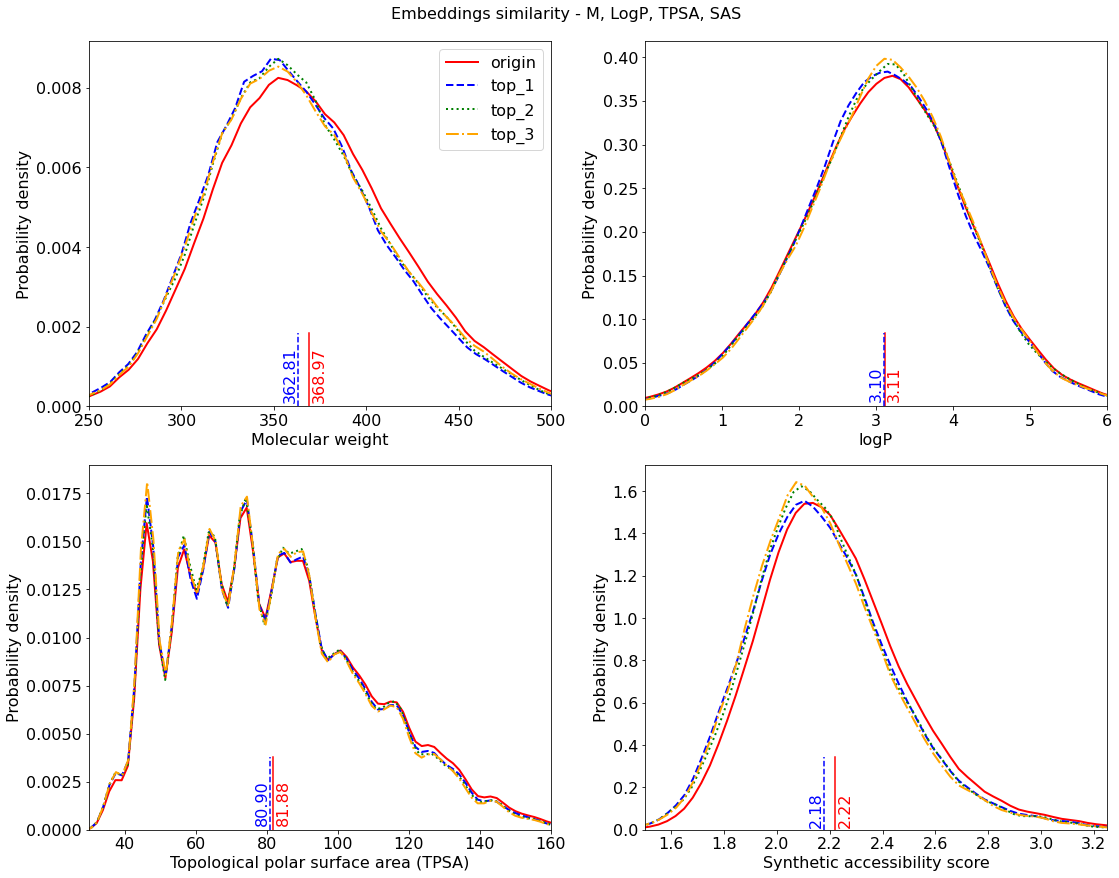

In [315]:
plot_df(embd_df, 'Embeddings similarity - M, LogP, TPSA, SAS')

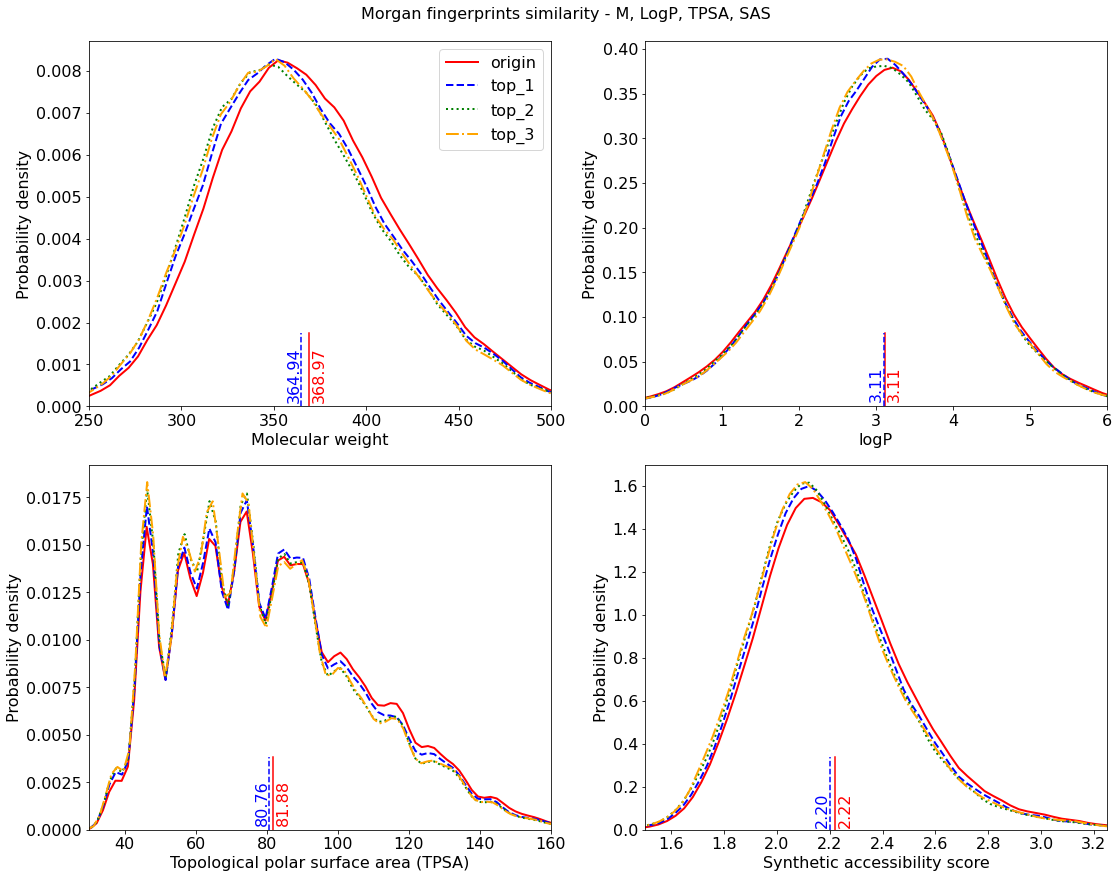

In [314]:
plot_df(morgan_df, 'Morgan fingerprints similarity - M, LogP, TPSA, SAS')

# Tanimoto Similarity

In [183]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

def get_tanimoto_similarity_from_mol(row):
    morgan_fp_1 = AllChem.GetMorganFingerprintAsBitVect(row.origin_mol, 2)
    morgan_fp_2 = AllChem.GetMorganFingerprintAsBitVect(row.top_1_mol, 2)
    morgan_fp_3 = AllChem.GetMorganFingerprintAsBitVect(row.top_2_mol, 2)
    morgan_fp_4 = AllChem.GetMorganFingerprintAsBitVect(row.top_3_mol, 2)
    
    return DataStructs.TanimotoSimilarity(morgan_fp_1, morgan_fp_2),\
           DataStructs.TanimotoSimilarity(morgan_fp_1, morgan_fp_3),\
           DataStructs.TanimotoSimilarity(morgan_fp_1, morgan_fp_4)

def append_similarity(df):
    sim_dict = {'origin_to_top_1_tanim':[],
                'origin_to_top_2_tanim':[],
                'origin_to_top_3_tanim':[]
               }
    
    for i, row in df.iterrows():
        a, b, c = get_tanimoto_similarity_from_mol(row)
        sim_dict['origin_to_top_1_tanim'].append(a)
        sim_dict['origin_to_top_2_tanim'].append(b)
        sim_dict['origin_to_top_3_tanim'].append(c)
    
    sim_df = pd.DataFrame.from_dict(sim_dict)
    
    return pd.concat([df, sim_df], axis=1, sort=False)

In [185]:
%%time
embd_df = append_similarity(embd_df)
morgan_df = append_similarity(morgan_df)

CPU times: user 1min 52s, sys: 9.07 s, total: 2min 1s
Wall time: 2min 9s


In [232]:
def plot_sim(df1, df2, name):
    fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(16,8))

    sns.distplot(df1.origin_to_top_1_tanim, hist = False, kde = True, kde_kws = {'linewidth': 2}, label="origin to top_1", ax=ax[0])
    sns.distplot(df1.origin_to_top_2_tanim, hist = False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 2}, label="origin to top_2", ax=ax[0])
    sns.distplot(df1.origin_to_top_3_tanim, hist = False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 2}, label="origin to top_3", ax=ax[0])
    ax[0].set(xlabel='Tanimoto similarity', ylabel='Probability density')
    ax[0].set_xlim(0.3, 1.0)
    ax[0].set_ylim(0, 9.1)
    ax[0].axvline(df1.origin_to_top_1_tanim.mean(), color=flat[0], ymax=0.1)
    ax[0].axvline(df1.origin_to_top_2_tanim.mean(), color=flat[1], linestyle='dashed', ymax=0.1)
    ax[0].axvline(df1.origin_to_top_3_tanim.mean(), color=flat[2], linestyle='dotted', ymax=0.1)
    ax[0].annotate('{:.2f}'.format(df1.origin_to_top_1_tanim.mean()), xy=(df1.origin_to_top_1_tanim.mean(), 0.1), color=flat[0], ha='right', va='bottom', rotation=90)
    ax[0].annotate('{:.2f}'.format(df1.origin_to_top_2_tanim.mean()), xy=(df1.origin_to_top_2_tanim.mean(), 0.1), color=flat[1], ha='right', va='bottom', rotation=90)
    ax[0].annotate('{:.2f}'.format(df1.origin_to_top_3_tanim.mean()), xy=(df1.origin_to_top_3_tanim.mean(), 0.1), color=flat[2], ha='right', va='bottom', rotation=90)
    ax[0].set_title('Embeddings')

    sns.distplot(df2.origin_to_top_1_tanim, hist = False, kde = True, kde_kws = {'linewidth': 2}, ax=ax[1])
    sns.distplot(df2.origin_to_top_2_tanim, hist = False, kde = True, kde_kws = {'linestyle':'dashed', 'linewidth': 2}, ax=ax[1])
    sns.distplot(df2.origin_to_top_3_tanim, hist = False, kde = True, kde_kws = {'linestyle':'dotted', 'linewidth': 2}, ax=ax[1])
    ax[1].set(xlabel='Tanimoto similarity', ylabel='Probability density')
    ax[1].set_xlim(0.3, 1.0)
    ax[1].set_ylim(0, 9.1)
    ax[1].axvline(df2.origin_to_top_1_tanim.mean(), color=flat[0], ymax=0.1)
    ax[1].axvline(df2.origin_to_top_2_tanim.mean(), color=flat[1], linestyle='dashed', ymax=0.1)
    ax[1].axvline(df2.origin_to_top_3_tanim.mean(), color=flat[2], linestyle='dotted', ymax=0.1)
    ax[1].annotate('{:.2f}'.format(df2.origin_to_top_1_tanim.mean()), xy=(df2.origin_to_top_1_tanim.mean(), 0.15), color=flat[0], ha='right', va='bottom', rotation=90)
    ax[1].annotate('{:.2f}'.format(df2.origin_to_top_2_tanim.mean()), xy=(df2.origin_to_top_2_tanim.mean(), 0.15), color=flat[1], ha='right', va='bottom', rotation=90)
    ax[1].annotate('{:.2f}'.format(df2.origin_to_top_3_tanim.mean()), xy=(df2.origin_to_top_3_tanim.mean(), 0.15), color=flat[2], ha='right', va='bottom', rotation=90)
    ax[1].set_title('Morgan fingerprints')

    fig.suptitle(name, fontsize=16, x=0.5, y=1.02)
    plt.tight_layout()
    plt.savefig(name+'.png')

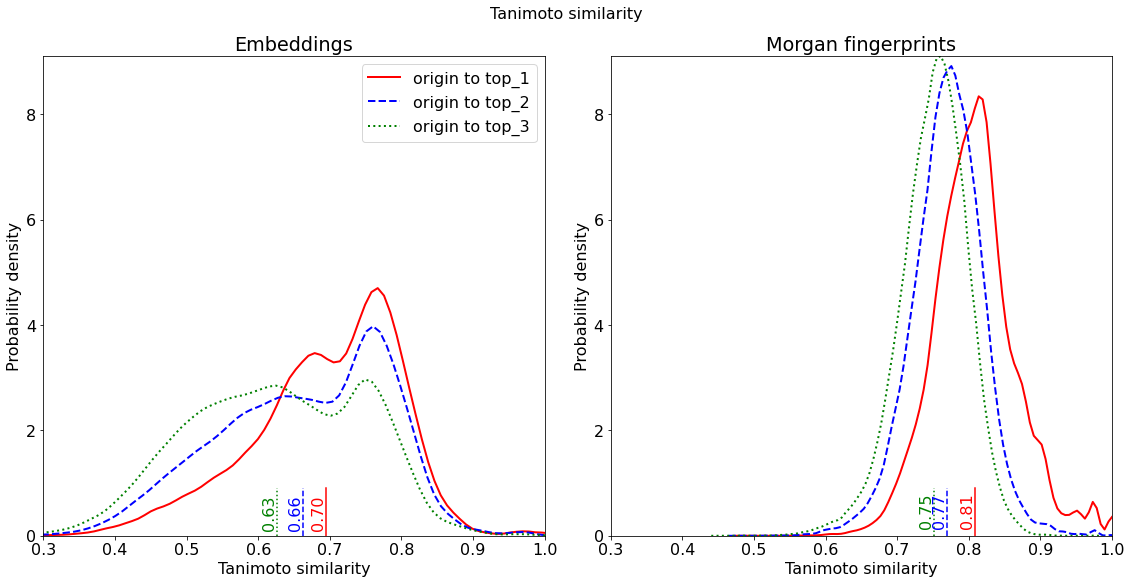

In [233]:
plot_sim(embd_df, morgan_df, 'Tanimoto similarity')

# Common functional groups

In [168]:
from rdkit import Chem
from collections import namedtuple

def merge(mol, marked, aset):
    bset = set()
    for idx in aset:
        atom = mol.GetAtomWithIdx(idx)
        for nbr in atom.GetNeighbors():
            jdx = nbr.GetIdx()
            if jdx in marked:
                marked.remove(jdx)
                bset.add(jdx)
    if not bset:
        return
    merge(mol, marked, bset)
    aset.update(bset)

# atoms connected by non-aromatic double or triple bond to any heteroatom
# c=O should not match (see fig1, box 15).  I think using A instead of * should sort that out?
PATT_DOUBLE_TRIPLE = Chem.MolFromSmarts('A=,#[!#6]')
# atoms in non aromatic carbon-carbon double or triple bonds
PATT_CC_DOUBLE_TRIPLE = Chem.MolFromSmarts('C=,#C')
# acetal carbons, i.e. sp3 carbons connected to tow or more oxygens, nitrogens or sulfurs; these O, N or S atoms must have only single bonds
PATT_ACETAL = Chem.MolFromSmarts('[CX4](-[O,N,S])-[O,N,S]')
# all atoms in oxirane, aziridine and thiirane rings
PATT_OXIRANE_ETC = Chem.MolFromSmarts('[O,N,S]1CC1')

PATT_TUPLE = (PATT_DOUBLE_TRIPLE, PATT_CC_DOUBLE_TRIPLE, PATT_ACETAL, PATT_OXIRANE_ETC)

def identify_functional_groups(mol):
    marked = set()
    # mark all heteroatoms in a molecule, including halogens
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() not in (6,1): # would we ever have hydrogen?
            marked.add(atom.GetIdx())

    # mark the four specific types of carbon atom
    for patt in PATT_TUPLE:
        for path in mol.GetSubstructMatches(patt):
            for atomindex in path:
                marked.add(atomindex)

    # merge all connected marked atoms to a single FG
    groups = []
    while marked:
        grp = set([marked.pop()])
        merge(mol, marked, grp)
        groups.append(grp)

    # extract also connected unmarked carbon atoms
    ifg = namedtuple('IFG', ['atomIds', 'atoms', 'type'])
    ifgs = []
    for g in groups:
        uca = set()
        for atomidx in g:
            for n in mol.GetAtomWithIdx(atomidx).GetNeighbors():
                if n.GetAtomicNum() == 6:
                    uca.add(n.GetIdx())
        ifgs.append(ifg(atomIds=tuple(list(g)), atoms=Chem.MolFragmentToSmiles(mol, g, canonical=True), type=Chem.MolFragmentToSmiles(mol, g.union(uca),canonical=True)))
    return ifgs

In [170]:
def get_func_groups_from_mol(m):
    m = Chem.AddHs(m)
    return identify_functional_groups(m)

In [171]:
%%time

for c in tqdm(embd_df.columns):
    if c.endswith('_mol'):
        embd_df[c+'_fgr'] = embd_df[c].apply(get_func_groups_from_mol)
        
for c in tqdm(morgan_df.columns):
    if c.endswith('_mol'):
        morgan_df[c+'_fgr'] = morgan_df[c].apply(get_func_groups_from_mol)


100%|██████████| 24/24 [07:01<00:00, 17.54s/it][A

100%|██████████| 24/24 [07:00<00:00, 17.50s/it][A

CPU times: user 12min 49s, sys: 19.6 s, total: 13min 9s
Wall time: 14min 1s


In [304]:
def count_to_frequency(count, total):
    return count / total

def get_fg_freq(df):
    fg_orig = dict()
    fg_top1 = dict()
    fg_top2 = dict()
    fg_top3 = dict()

    for index, row in df.filter(like='_fgr', axis=1).iterrows():
        for ifg in row['origin_mol_fgr']:
            if ifg.type in func_groups.keys():
                fg_orig[ifg.type] += 1
            else:
                fg_orig[ifg.type] = 1
        for ifg in row['top_1_mol_fgr']:
            if ifg.type in func_groups.keys():
                fg_top1[ifg.type] += 1
            else:
                fg_top1[ifg.type] = 1
        for ifg in row['top_2_mol_fgr']:
            if ifg.type in func_groups.keys():
                fg_top2[ifg.type] += 1
            else:
                fg_top2[ifg.type] = 1
        for ifg in row['top_3_mol_fgr']:
            if ifg.type in func_groups.keys():
                fg_top3[ifg.type] += 1
            else:
                fg_top3[ifg.type] = 1
                
    fg_orig = sorted(fg_orig.items(), key=lambda kv: kv[1], reverse=True)
    fg_top1 = sorted(fg_top1.items(), key=lambda kv: kv[1], reverse=True)
    fg_top2 = sorted(fg_top2.items(), key=lambda kv: kv[1], reverse=True)
    fg_top3 = sorted(fg_top3.items(), key=lambda kv: kv[1], reverse=True)
    
    fg_orig_tot = 0
    fg_top1_tot = 0
    fg_top2_tot = 0
    fg_top3_tot = 0
    
    for k, a1 in fg_orig:
        fg_orig_tot += a1
    for k, a2 in fg_top1:
        fg_top1_tot += a2
    for k, a3 in fg_top2:
        fg_top2_tot += a3
    for k, a4 in fg_top3:
        fg_top3_tot += a4
        
    fg_orig_freq = dict((k, count_to_frequency(v, fg_orig_tot)) for k, v in fg_orig)
    fg_top1_freq = dict((k, count_to_frequency(v, fg_top1_tot)) for k, v in fg_top1)
    fg_top2_freq = dict((k, count_to_frequency(v, fg_top2_tot)) for k, v in fg_top2)
    fg_top3_freq = dict((k, count_to_frequency(v, fg_top3_tot)) for k, v in fg_top3)
                
    return fg_orig_freq, fg_top1_freq, fg_top2_freq, fg_top3_freq

def fg_freq_to_legend(a, b, c, d):
    i = 0
    func_groups = []
    legend = []

    for k in a.keys():
        i += 1

        func_groups.append(k)
        legend.append('{} {}% {}% {}% {}%'
            .format(k,
                    round(a.get(k)*100, 1),
                    round(b.get(k)*100, 1),
                    round(c.get(k)*100, 1),
                    round(d.get(k)*100, 1)
                    ))

        if i == 25:
            break
    return func_groups, legend

def get_mols_and_matches(func_groups, source_df):
    mols = []
    smiles_unique = []
    substructure_matches = []

    for substr in func_groups:
        smarts = Chem.MolFromSmarts(substr)

        for index, row in source_df.iterrows():
            smiles = row['origin']
            mol = Chem.MolFromSmiles(smiles)
            match = mol.GetSubstructMatch(smarts)

            if match and smiles not in smiles_unique:
                mols.append(mol)
                substructure_matches.append(match)
                smiles_unique.append(smiles)
                break
    return mols, substructure_matches

In [305]:
a, b, c, d = get_fg_freq(embd_df)
e, f, g, h = get_fg_freq(morgan_df)

In [306]:
fg_embd, legend_embd = fg_freq_to_legend(a, b, c, d)
fg_morg, legend_morg = fg_freq_to_legend(e, f, g, h)

In [307]:
fg_embd_mols, fg_embd_matches = get_mols_and_matches(fg_embd, embd_df)
fg_morg_mols, fg_morg_matches = get_mols_and_matches(fg_morg, morgan_df)

In [311]:
from rdkit.Chem.Draw import MolsToGridImage

regular_atom_color = (0,0,0)
highlight_color = (1, 0, 0)  # pure red
highlight_atom_size = 0.5

def mols_to_grid_img(mols, legend, matches, name):
    img = MolsToGridImage(mols, 
                          molsPerRow=5, 
                          legends=legend, 
                          highlightAtomLists=matches
#                 highlightBondColors=[(1,0,0)],
    )
    img.save(name+".png","PNG")
    return img

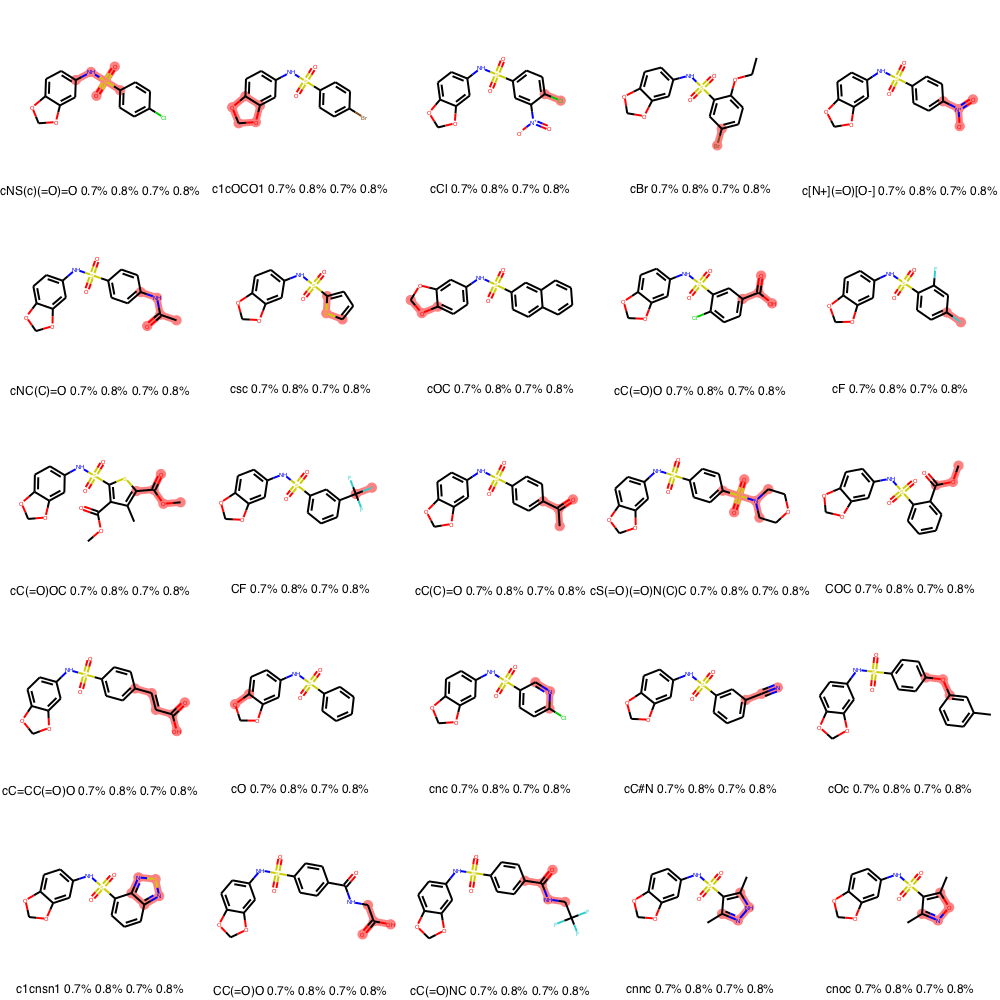

In [312]:
mols_to_grid_img(fg_embd_mols, legend_embd, fg_embd_matches, 'Embeddings similarity - functional groups comparison')

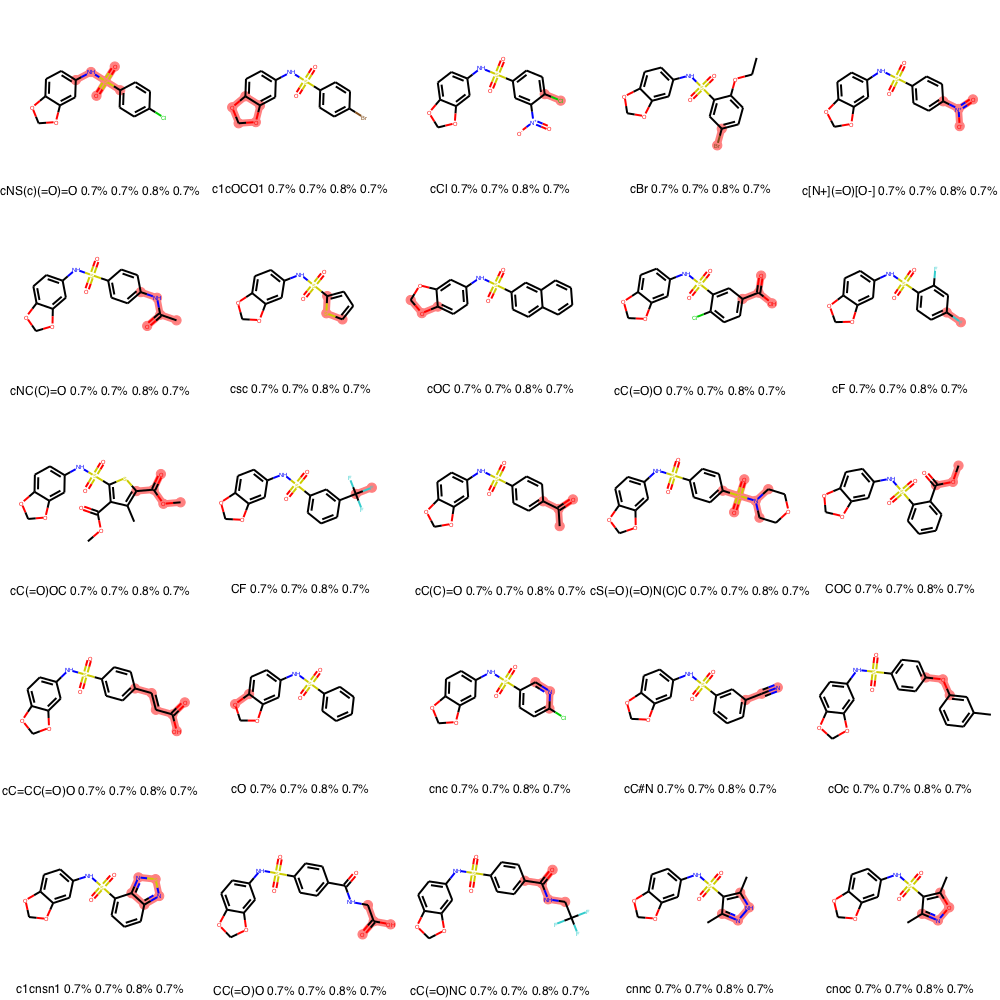

In [313]:
mols_to_grid_img(fg_morg_mols, legend_morg, fg_morg_matches, 'Morgan fingerprints similarity - functional groups comparison')